# Forward-Backward algorithm using pywrapfst

This notebook illustrates the use of [pywrapfst](https://github.com/beer-asr/pywrapfst) by providing an example of the *forward-backward* algorithm for Hidden Markov Model (HMM). The example shows how to construct the trellis of hypotheses and then compute the *forward-backward* algorithm which gives the probability to be in a specific state at a specific time frame given all the observations. 

NOTE: all along this notebook we shall denote by FST all possible grap

Before to starts, let's import the two modules we will need.

In [1]:
import pywrapfst as fst
import numpy as np

# Settings

We define some global constants here but feel free to change it as you see fit. The first one, ``nstates``, is the number of states in the HMM and the second one, ``nframes`` is the length of the sequence on which to run the *forward-backward* algorithm. Also, we define a symbol table to make the display of the FST more readable.

In [2]:
nstates = 3
nframes = 5
syms = fst.SymbolTable()

# We reserve the 0th index to the special epsilon symbol.
syms.add_symbol('ε')
for i in range(nstates):
    syms.add_symbol(''.join(['s', str(i+1)]))

# Model 

The first step is to build the HMM structure. In our example, we will use the *left-to-right* topology.

In [3]:
def create_hmm(nstates):
    '''Create a left-to-right HMM FST.
    
    The arcs' weight of the FST will be in the log semiring. 
    
    Args:
        nstates (int): number of emitting states.
        
    Returns:
        :class:`fst.Fst`: The FST representation of the HMM.
    
    '''
    # Create the FST, the symbol table.
    hmm, syms = fst.Fst('log'), fst.SymbolTable()
    
    # Create the states of the FST and specify the initial/final states.
    states = [hmm.add_state() for i in range(nstates + 1)]
    hmm.set_start(states[0]), hmm.set_final(states[-1])
    
    # Add the arcs of the fst.
    for idx, state in enumerate(states[:-1]):
        label = idx + 1
        
        # Self loop.
        arc = fst.Arc(label, label, fst.Weight('log', -np.log(1/2)), state)
        hmm.add_arc(state, arc)
        
        # Forward loop.
        arc = fst.Arc(label, label, fst.Weight('log', -np.log(1/2)), states[idx + 1])
        hmm.add_arc(state, arc)
        
    # Set the symbol table of the fst.
    hmm.set_input_symbols(syms), hmm.set_output_symbols(syms)
    
    return hmm

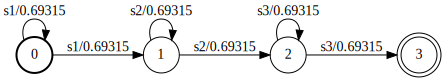

In [4]:
hmm = create_hmm(nstates=3)
hmm.set_input_symbols(syms), hmm.set_output_symbols(syms)
hmm

# Observations

Before to run the *forward-backward* algorithm we need to compute the (log-)likelihood of the observations for each state. In speech it is common that these likelihoods are given by some Gaussian Mixture Models. However, for the sake of brevity, we will assume the per-state log-likelihood has already been computed for us. These log-likelihoods are stored in a $N \times K$ matrix where $N$ is the number of observation and $K$ is the number of states in our HMM.

In [5]:
llhs = np.random.uniform(low=-10., high=0., size=(nframes, nstates))
llhs 

array([[-8.2377952 , -3.18547329, -6.27837274],
       [-9.9681806 , -3.49184682, -1.84343588],
       [-4.26801324, -1.90633097, -2.37657465],
       [-0.53172343, -5.850942  , -1.04257361],
       [-5.10075681, -9.88113142, -8.72695693]])

To work with the OpenFst framework, we need to convert the matrix of log-likelihood into a FST. 

In [6]:
def get_fst_llhs(llhs):
    '''Convert a matrix of log-likelihoods into a FST.
    
    Args:
        llhs (numpy.ndarray): NxD matrix of log-likelihood.
     
    Returns:
        :class:`fst.Fst`: FST representing the log-likelihood matrix.
        
    '''
    # Create the FST
    llhs_fst = fst.Fst('log')
    
    # Create the states of the FST.
    states = [llhs_fst.add_state() for i in range(llhs.shape[0] + 1)]
    
    # Set initial and final states.
    llhs_fst.set_start(states[0]), llhs_fst.set_final(states[-1])
    
    # Create the arcs.
    for frame in range(llhs.shape[0]):
        for state in range(llhs.shape[1]):
            label = state + 1
            weight = fst.Weight(llhs_fst.weight_type(), -llhs[frame, state])
            arc = fst.Arc(label, label, weight, frame + 1)
            llhs_fst.add_arc(frame, arc)
        
    return llhs_fst

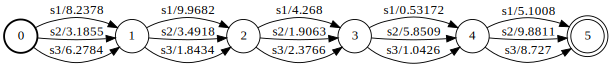

In [7]:
llhs_fst = get_fst_llhs(llhs)
llhs_fst.set_input_symbols(syms), llhs_fst.set_output_symbols(syms)
llhs_fst

# Forward-Backward algorithm

Let $U$ be the FST representing the per-state log-likelihood FST and $H$ the HMM FST. Then, within the FST framework, the forward-backward algorithm gpes as follow:

1. Compose the two FSTs to get the trellis of hypotheses $L = U \circ H$.
2. Get the forward quantities $\alpha(s, i)$ for each possible pair of HMM state $s$ and frame index $i$ by running the *shortest-distance* algorithm on $L$ in the log-semiring.
3. Get the backward quantities $\beta(s, t)$ for each possible pair of HMM state $s$ and frame index $t$ by running the reverse *shortest-distance* algorithm on $L$ in the log-semiring.
1. Then, the probability to be in state $s$ for the frame index $t$ given the observed sequence $X_{1:T}$ is given by: 

$$
p(S_t = s | X_{1:T}) = \frac{\alpha(s, t)\beta(s, t)}{p(X_{1:T})}
$$

1st step: composition of the log-likelihoods and the HMM.

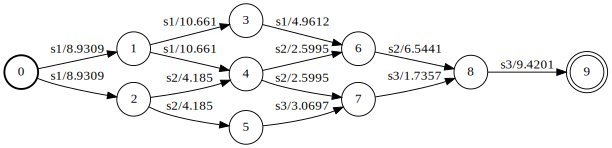

In [8]:
L = fst.compose(llhs_fst, hmm)
L

2nd and 3rd steps: We compute the (log) forward and backward quantities.

In [9]:
# Note the return value of fst.shortestdistance is a list of
# fst.Weight objects. We convert them to a float value to work
# naturally with it in python.
log_alphas = -np.asarray([float(val) for val in fst.shortestdistance(L)])
log_betas = -np.asarray([float(val) for val in fst.shortestdistance(L, reverse=True)])
print(log_alphas)
print(log_betas)

[ -0.          -8.93094254  -8.93094254 -19.5922699  -13.114398   -13.1159363
 -15.7138767  -15.2290516  -16.9597607  -26.3798656 ]
[-26.3808155  -24.4085045  -17.449873   -20.925354   -13.7471762
 -14.2255478  -15.9641943  -11.1558256   -9.42010498  -0.        ]


4th step: use forward and backward quantities to compute the final probabilities. 

In [10]:
probs = np.exp(log_alphas + log_betas - log_alphas[-1])
print(probs)

[  9.99050551e-01   9.49493912e-04   9.99050511e-01   7.24518674e-07
   6.17727041e-01   3.82273675e-01   5.00055986e-03   9.95000937e-01
   9.99999920e-01   1.00000000e+00]


5th step: we need to retrieve the hmm state / frame information for each probability. 

In [11]:
def get_matrix(trellis, probs, nframes, nstates):
    '''Get a N x K matrix of probabilities given a lattice.
    
    N is the number of frames and K is the number
    of HMM states
    
    Args:
        trellis (:class:`fst.Fst`): trellis which was used to compute
            the probabilities.
        probs (array_like): A list of probabilities, one for each state.
        nframes (int): Number of observed frames.
        nstates (int): Number of HMM states.
        
    Returns
        numpy.ndarray: A matrix of probabilities.
    
    '''
    prob_mat = np.zeros((nframes, nstates))
    queue = [(trellis.start(), 0)]
    while len(queue) > 0:
        state, frame = queue.pop()         
        for arc in trellis.arcs(state):
            hmm_state = arc.ilabel - 1
            prob_mat[frame, hmm_state] = probs[state]
            queue.append((arc.nextstate, frame + 1))
    return prob_mat

In [12]:
print('p(S_t = s | X):')
print(get_matrix(L, probs, nframes, nstates))

p(S_t = s | X):
[[  9.99050551e-01   0.00000000e+00   0.00000000e+00]
 [  9.49493912e-04   9.99050511e-01   0.00000000e+00]
 [  7.24518674e-07   6.17727041e-01   3.82273675e-01]
 [  0.00000000e+00   5.00055986e-03   9.95000937e-01]
 [  0.00000000e+00   0.00000000e+00   9.99999920e-01]]


That's it !